In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets

rng = np.random.default_rng()

## MNIST Dataset

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

mnist_trainset = mnist_trainset.data/255
mnist_testset = mnist_testset.data/255

print(mnist_trainset.shape)
print(mnist_testset.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


# CIFAR-10 Dataset

In [3]:
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

cifar10_classes = cifar10_trainset.classes
cifar10_trainlabels = torch.nn.functional.one_hot( torch.tensor(cifar10_trainset.targets), num_classes=10)
cifar10_testlabels = torch.nn.functional.one_hot( torch.tensor(cifar10_testset.targets), num_classes=10)

cifar10_trainset = torch.tensor((cifar10_trainset.data.astype(np.float32)/255)).permute(0,3,1,2)
cifar10_testset = torch.tensor(cifar10_testset.data.astype(np.float32)/255).permute(0,3,1,2)

print(cifar10_trainset.shape)
print(cifar10_testset.shape)

print(cifar10_trainlabels.shape)
print(cifar10_testlabels.shape)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([50000, 10])
torch.Size([10000, 10])


# Question 1 : Autoencoders

In [4]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, hidden_dim=32):

        super(AutoEncoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.encode_fc = torch.nn.Linear(28*28, self.hidden_dim, bias=True)
        self.decode_fc = torch.nn.Linear(self.hidden_dim, 28*28, bias=True)

    def encode(self, x):
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except batch
        # print(x.shape)
        code = torch.nn.functional.relu(self.encode_fc(x))
        return code
    
    def decode(self,code):
        out = self.decode_fc(code)
        out = torch.nn.functional.sigmoid(out)
        out = out.reshape(-1, 28, 28)
        return out

    def forward(self, x):

        code = self.encode(x)
        out = self.decode(code)
        return out


## Function to train the autoencoder

In [5]:
def train_autoencoder(hidden_dim, num_epochs = 5, batch_sz = 100):

    autoencoder = AutoEncoder(hidden_dim)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    

    num_trainsamples = mnist_trainset.shape[0]
    print(f"Starting training for Autoencoder with hidden dim = {hidden_dim}")
    autoencoder.train()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for j in range(0, num_trainsamples, batch_sz):

            inputs = mnist_trainset[j:j+batch_sz]
            labels = mnist_trainset[j:j+batch_sz]

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = autoencoder(inputs)     
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        loss = (running_loss/num_trainsamples) * batch_sz
        print(f'Epoch = {epoch + 1} and loss: {loss}')

    print(f'Finished Training of Auto Encoder for hidden dimesnsions = {hidden_dim}\n')
    return autoencoder

## Function to plot the reconstructions

In [6]:
def plot_reconstructions(autoencoder, dataset = "Train", hidden_dim= 64, indices = None, num=int(10)):

    criterion = torch.nn.BCELoss()

    f, axarr = plt.subplots(2, num, figsize=(num, 2))
    f.dpi = 225
    f.suptitle(f"{dataset} reconstructions by hidden dimension - {hidden_dim}", fontsize= 12)
    f.text(0, 0.65, "Reconstructions:")
    f.text(0, 0.25, "Original Images:")
    autoencoder.eval()

    print(f"\n{dataset} losses for {num} images with hidden dim= {hidden_dim}:")
    for i in range(num):
        with torch.no_grad():
            if dataset == "Train":
                input =  mnist_trainset[indices[i], :, :].reshape(1, 28, 28)
            else:
                input =  mnist_testset[indices[i], :, :].reshape(1, 28, 28)


            reconstruction = autoencoder(input)
            loss = criterion(input, reconstruction)
            print(f"Loss {i+1} = {loss.item()}")

            reconstruction  = reconstruction.permute(1,2,0).detach().numpy()
            input = input.permute(1,2,0).detach().numpy()

            axarr[0, i].axis("off")
            axarr[0, i].imshow(reconstruction, cmap='Greys')

            axarr[1, i].axis("off")
            axarr[1, i].imshow(input, cmap='Greys')

In [7]:
trained_autoencoder_64 = train_autoencoder(64)
trained_autoencoder_32 = train_autoencoder(32)

Starting training for Autoencoder with hidden dim = 64
Epoch = 1 and loss: 0.20608817125360174
Epoch = 2 and loss: 0.1253865852082769
Epoch = 3 and loss: 0.10206451342751582
Epoch = 4 and loss: 0.09054174605756998
Epoch = 5 and loss: 0.08474648728966713
Finished Training of Auto Encoder for hidden dimesnsions = 64

Starting training for Autoencoder with hidden dim = 32
Epoch = 1 and loss: 0.23302097042401634
Epoch = 2 and loss: 0.1513246668751041
Epoch = 3 and loss: 0.1283960272744298
Epoch = 4 and loss: 0.11738398376852274
Epoch = 5 and loss: 0.10975321080535651
Finished Training of Auto Encoder for hidden dimesnsions = 32



### Part a


Train losses for 10 images with hidden dim= 64:
Loss 1 = 1.674484372138977
Loss 2 = 0.40776026248931885
Loss 3 = 0.8789529800415039
Loss 4 = 0.43141019344329834
Loss 5 = 1.2340389490127563
Loss 6 = 0.6598706841468811
Loss 7 = 0.5493576526641846
Loss 8 = 0.5878122448921204
Loss 9 = 1.9442243576049805
Loss 10 = 0.8008049726486206

Test losses for 10 images with hidden dim= 64:
Loss 1 = 0.2965650260448456
Loss 2 = 0.6505627036094666
Loss 3 = 0.4009380340576172
Loss 4 = 0.5618073344230652
Loss 5 = 0.4165768623352051
Loss 6 = 2.896848440170288
Loss 7 = 0.27837687730789185
Loss 8 = 0.45458027720451355
Loss 9 = 0.2386542707681656
Loss 10 = 0.9742321372032166

Train losses for 10 images with hidden dim= 32:
Loss 1 = 2.560488224029541
Loss 2 = 0.7120018005371094
Loss 3 = 2.452603340148926
Loss 4 = 1.3144842386245728
Loss 5 = 3.0935728549957275
Loss 6 = 2.051398754119873
Loss 7 = 1.9213674068450928
Loss 8 = 0.8499881029129028
Loss 9 = 3.0469117164611816
Loss 10 = 2.4431169033050537

Test losses

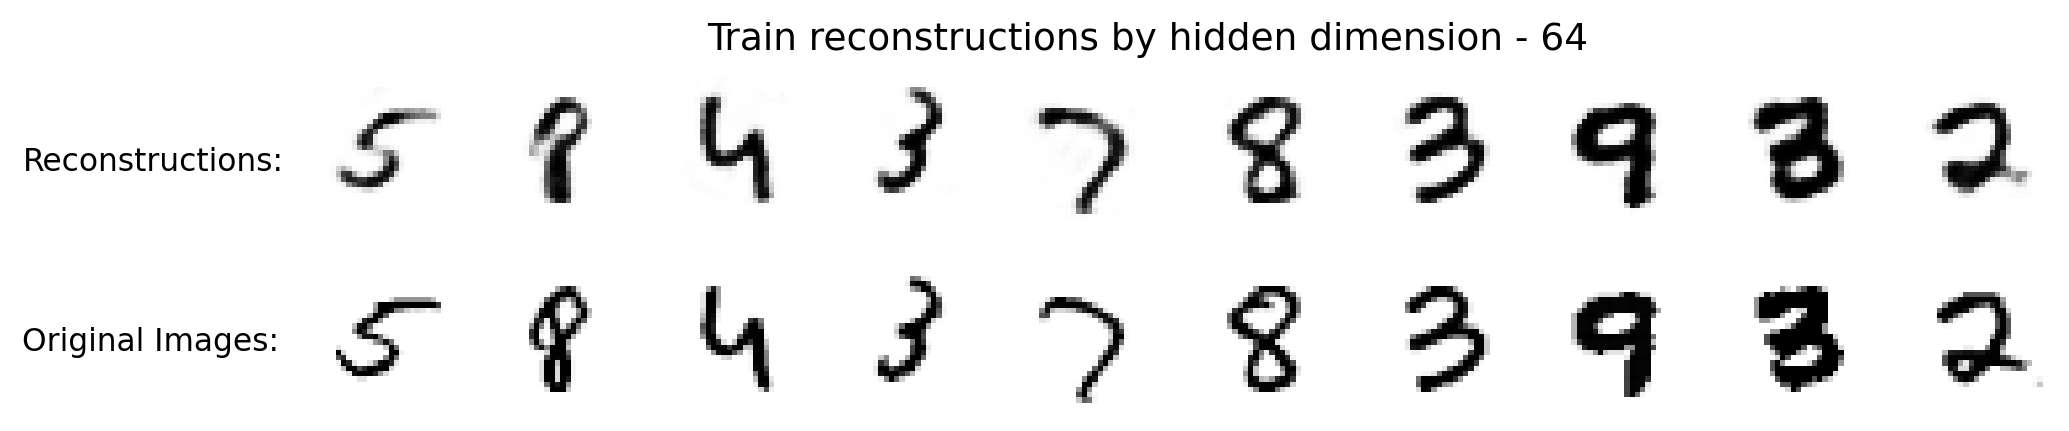

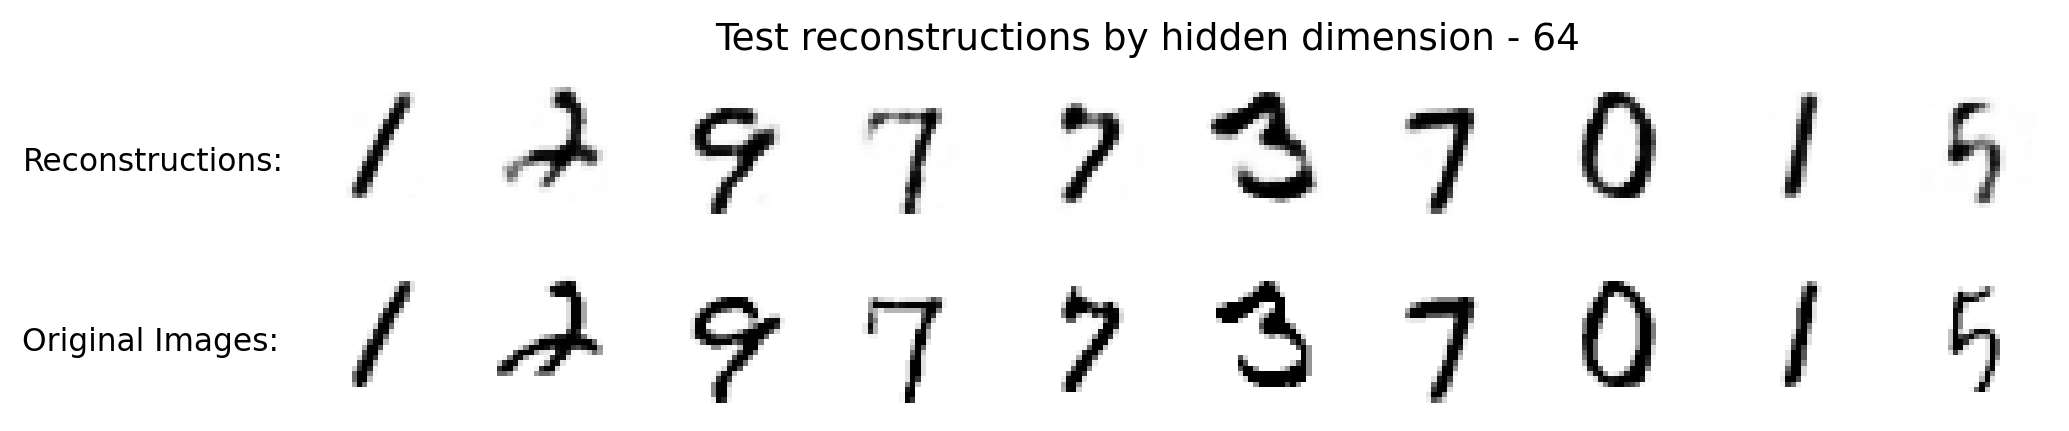

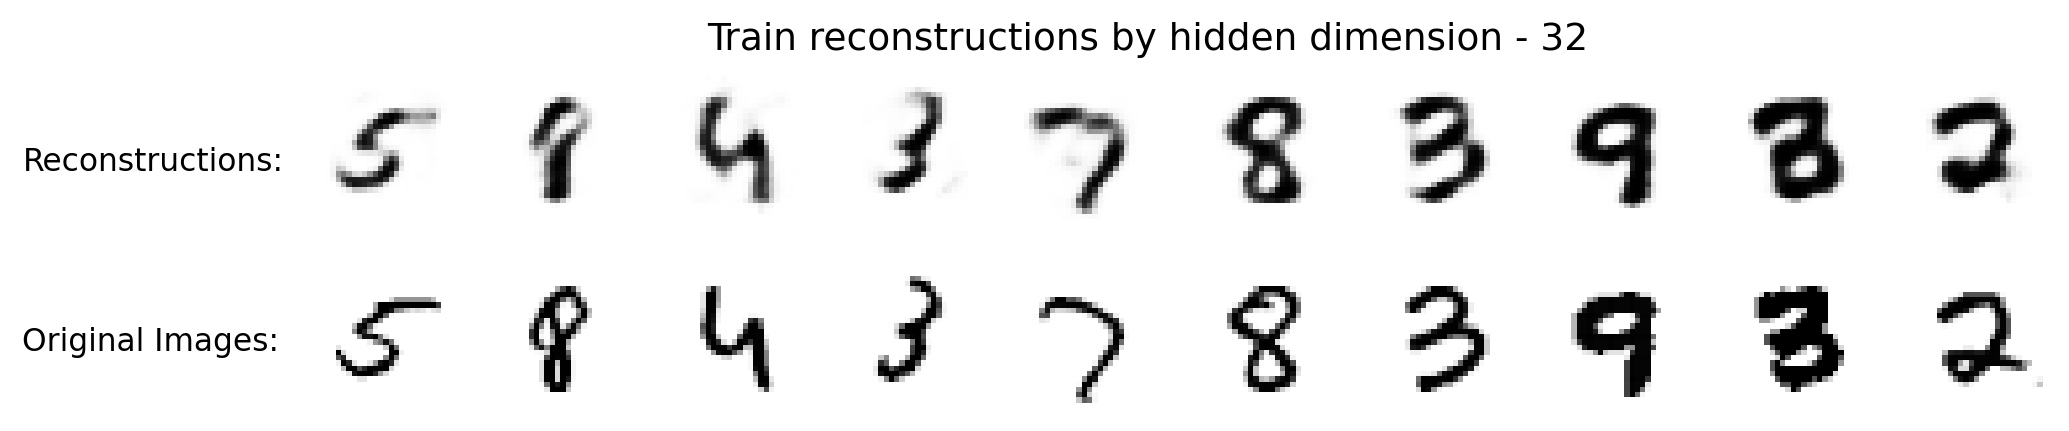

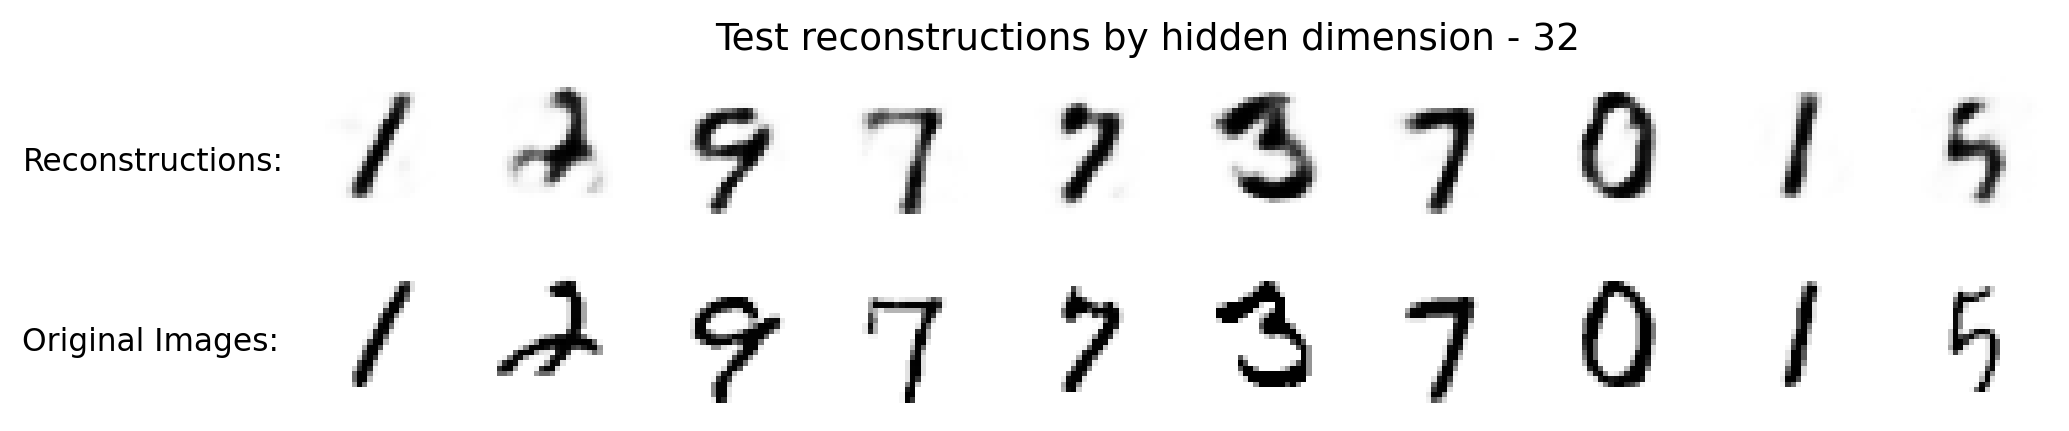

In [8]:
num_images = 10
indices = rng.integers(low=0, high=10000, size= num_images)

plot_reconstructions(trained_autoencoder_64, "Train", 64, indices,  num_images)
plot_reconstructions(trained_autoencoder_64, "Test", 64, indices, num_images)

plot_reconstructions(trained_autoencoder_32, "Train", 32, indices, num_images)
plot_reconstructions(trained_autoencoder_32, "Test", 32, indices, num_images)

### Part b

In [9]:
def plot_partb(autoencoder, dataset = "Train", hidden_dim= 64, indices = None, num=5):

    f, axarr = plt.subplots(num, 2*num, figsize=(10, 2.5))
    f.dpi = 225
    f.suptitle(f"{dataset} reconstructions by hidden dimension - {hidden_dim}", fontsize= 12)
    f.text(0, 0.5, "Reconstructions:")
    autoencoder.eval()
    
    for i in range(num):
        alpha = 1/(2*num)
        for j in range(2*num):
            with torch.no_grad():
                if dataset == "Train":
                    input =  alpha*mnist_trainset[indices[2*i], :, :].reshape(1, 28, 28)+ (1-alpha)*mnist_trainset[indices[2*i+1], :, :].reshape(1, 28, 28)
                else:
                    input =  alpha*mnist_testset[indices[2*i], :, :].reshape(1, 28, 28)+ (1-alpha)*mnist_testset[indices[2*i+1], :, :].reshape(1, 28, 28)

                reconstruction = autoencoder(input)
                reconstruction  = reconstruction.permute(1,2,0).detach().numpy()

                axarr[i, j].axis("off")
                axarr[i, j].imshow(reconstruction, cmap='Greys')

                alpha += 1/(2*num)

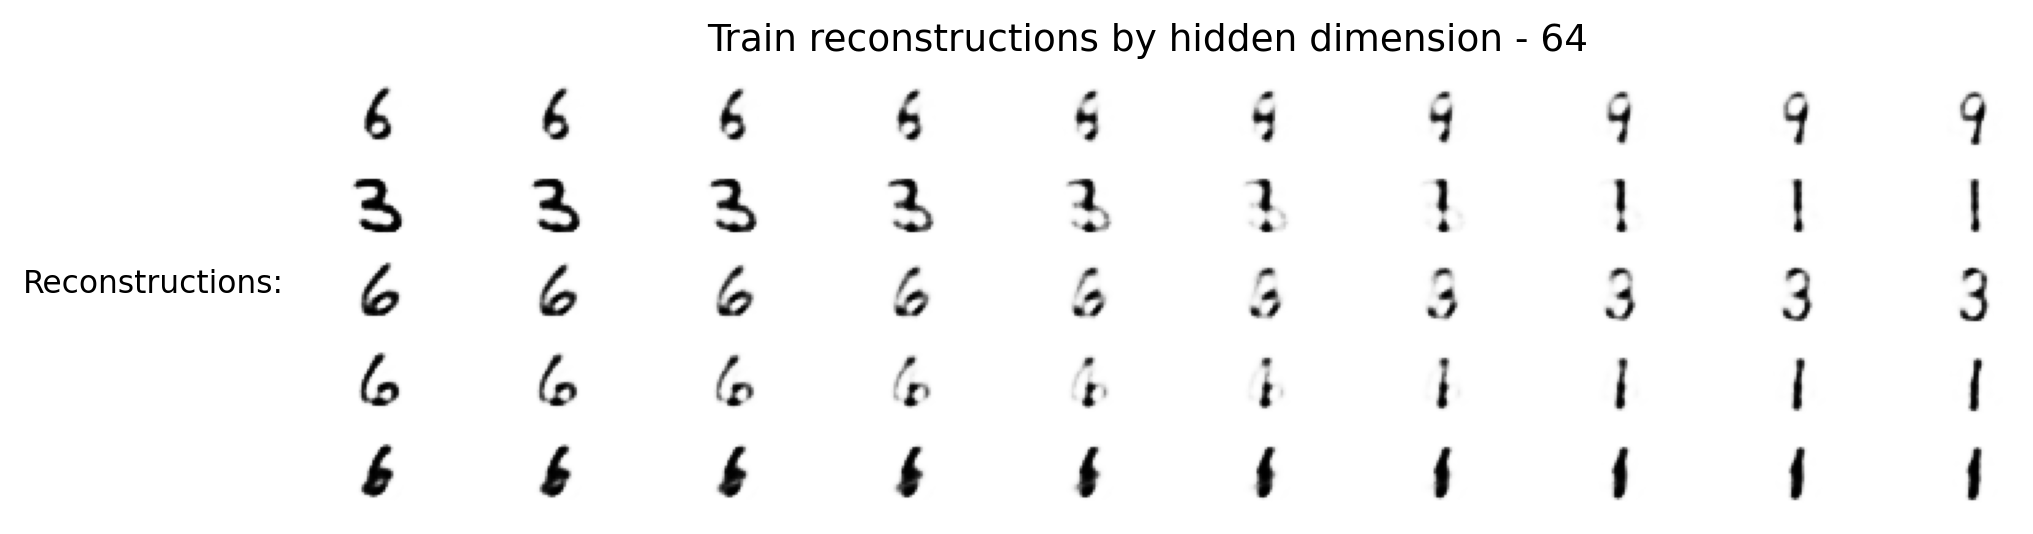

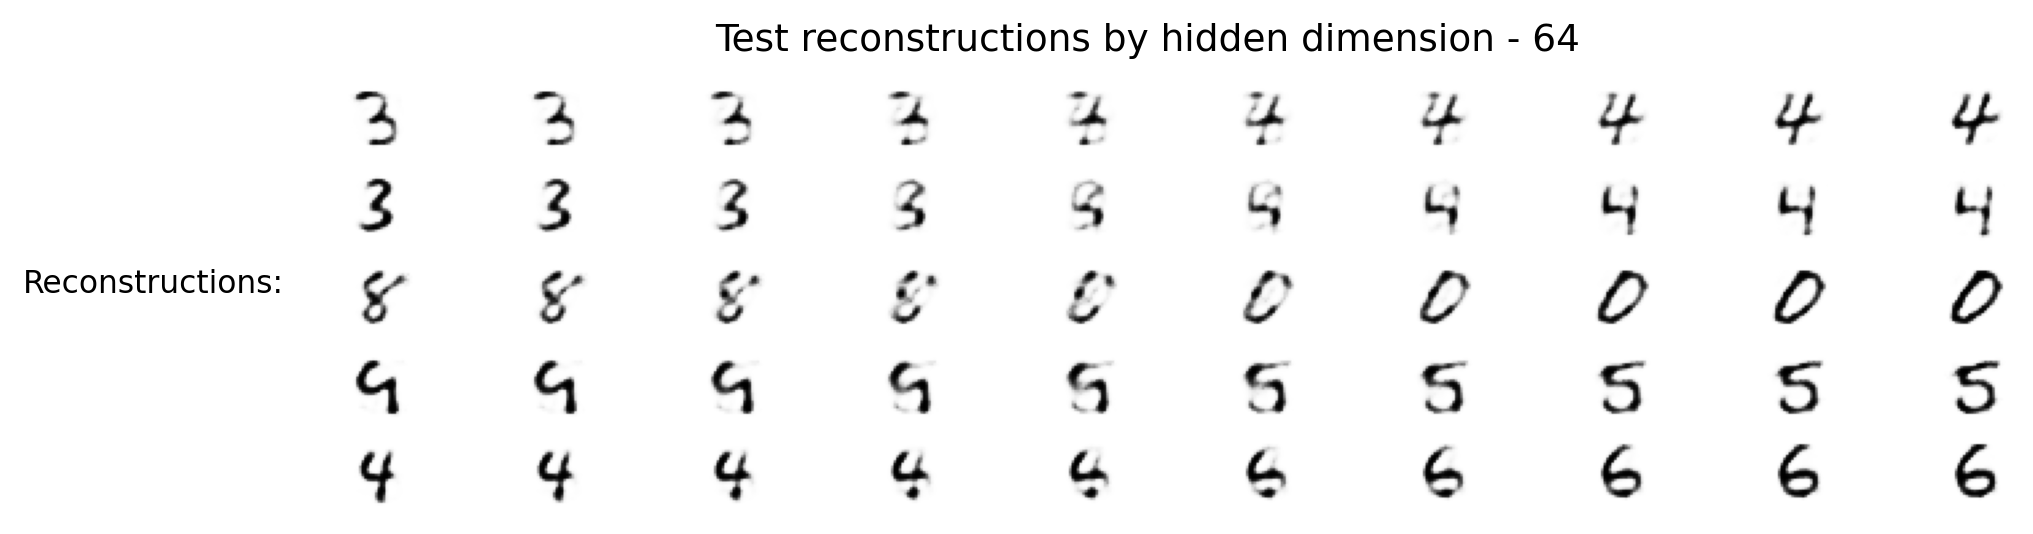

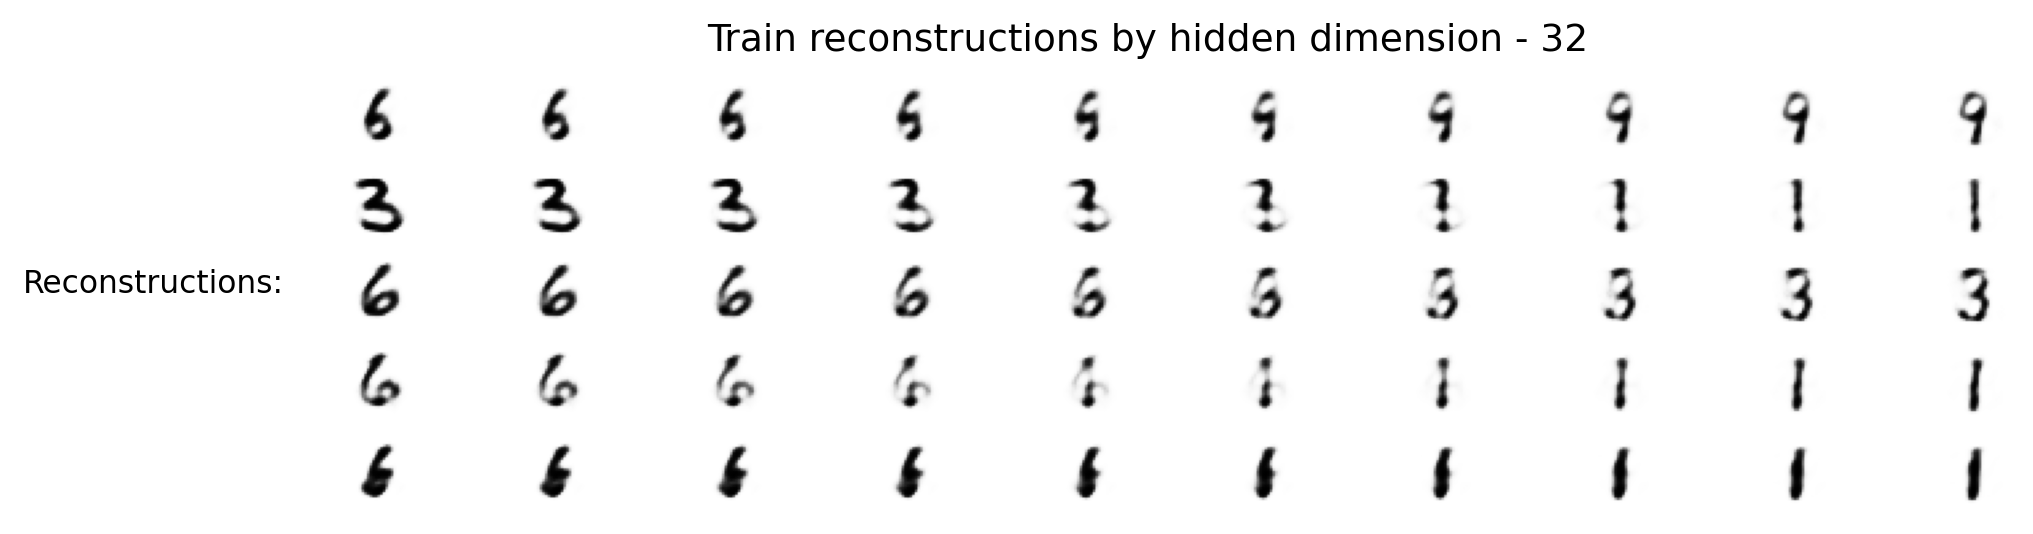

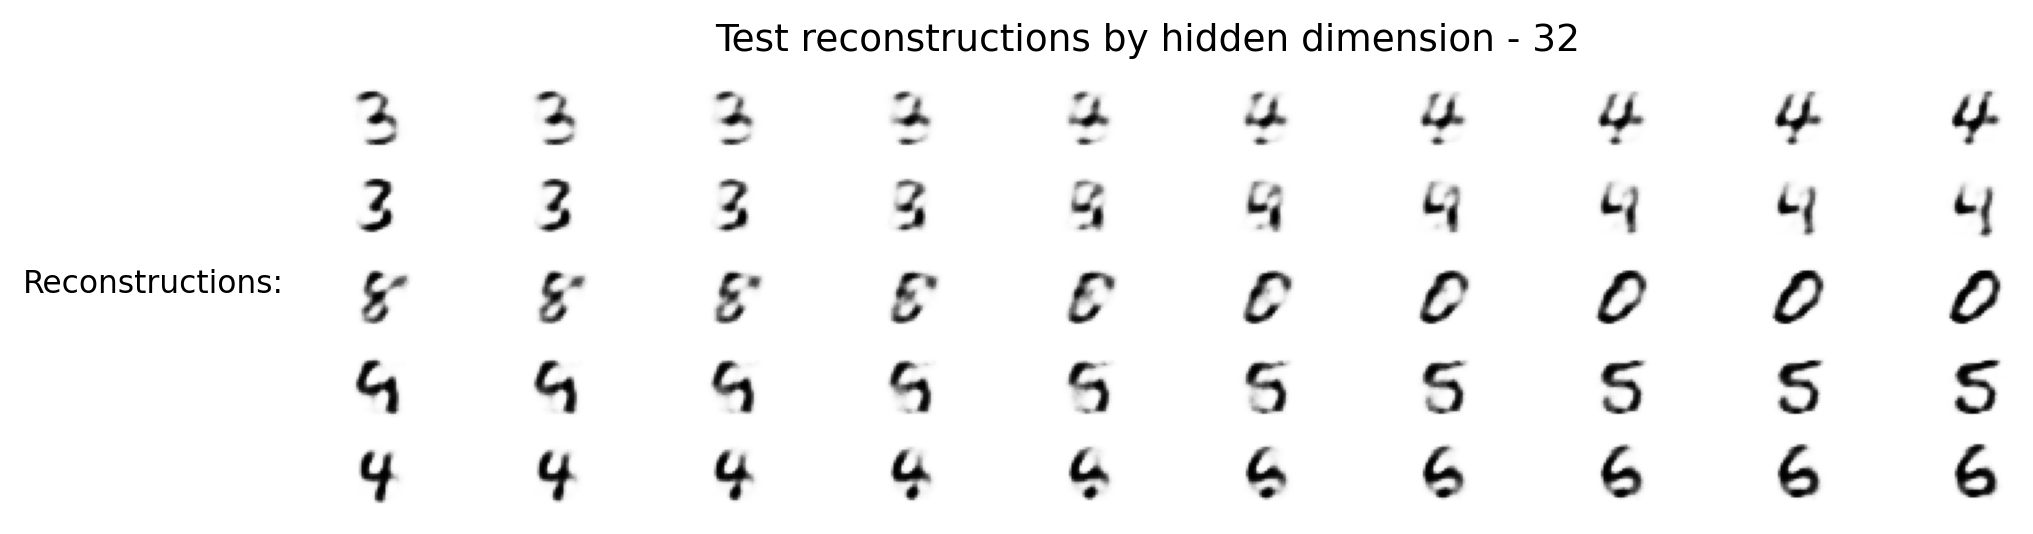

In [10]:
num_images = 5
indices = rng.integers(low=0, high=10000, size= 2*num_images)

plot_partb(trained_autoencoder_64, "Train", 64, indices,  num_images)
plot_partb(trained_autoencoder_64, "Test", 64, indices, num_images)

plot_partb(trained_autoencoder_32, "Train", 32, indices, num_images)
plot_partb(trained_autoencoder_32, "Test", 32, indices, num_images)

# Question 2 Variational Autoencoder

In [11]:
class VAE(torch.nn.Module):

    def __init__(self, hidden_dim = 64, sampling_dim= 16):

        super(VAE, self).__init__()

        self.hidden_dim = hidden_dim
        self.sampling_dim = sampling_dim

        self.encode_fc = torch.nn.Linear(28*28, self.hidden_dim)
        self.get_mean = torch.nn.Linear(self.hidden_dim, self.sampling_dim)
        self.get_logvar = torch.nn.Linear(self.hidden_dim, self.sampling_dim)

        self.decode_fc1 = torch.nn.Linear(self.sampling_dim , self.hidden_dim)
        self.decode_fc2 = torch.nn.Linear(self.hidden_dim, 28*28)


    def forward(self, x):

        x = torch.flatten(x, start_dim=1) # flatten all dimensions except batch

        code = torch.nn.functional.relu(self.encode_fc(x))

        # Encoded dimension is code
        mean = self.get_mean(code)
        log_var = self.get_logvar(code)

        std = torch.exp(0.5 * log_var)

        epsilon = torch.randn_like(std)
        sampled_z =  mean + torch.multiply(std, epsilon)

        out = torch.nn.functional.relu(self.decode_fc1(sampled_z))
        out = torch.nn.functional.sigmoid(self.decode_fc2(out))

        out = out.reshape(-1, 28, 28)
        return out, mean, log_var
    
    def generate_samples(self, num=64):

        with torch.no_grad():
            samples = torch.randn(num, self.sampling_dim)
            out = torch.nn.functional.relu(self.decode_fc1(samples))
            out = torch.nn.functional.sigmoid(self.decode_fc2(out))

            out = out.reshape(-1, 28, 28)
            return out

## Function to Train VAE

In [12]:
def train_VAE(hidden_dim=64, sampling_dim= 16, num_epochs=10, batch_sz=100):

    vae = VAE(hidden_dim, sampling_dim)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)

    num_trainsamples = mnist_trainset.shape[0]
    print(f"Starting training for Variational Autoencoder with hidden dim = {hidden_dim}")
    vae.train()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for j in range(0, num_trainsamples, batch_sz):

            inputs = mnist_trainset[j:j+batch_sz]
            labels = mnist_trainset[j:j+batch_sz]

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs, mean, logvar = vae(inputs)

            kl_loss= torch.distributions.kl.kl_divergence(torch.distributions.Normal(mean, logvar.exp())
                                                           , torch.distributions.Normal(torch.zeros_like(mean)
                                                                                        , torch.ones_like(logvar)))
            kl_loss = torch.mean(kl_loss)

            recon_loss = criterion(outputs, labels)
           
            # compute total loss as a linear combination of reconstruction and KL divergence losses

            loss =  50 * recon_loss + kl_loss
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        loss = (running_loss/num_trainsamples) * batch_sz
        print(f'Epoch = {epoch + 1} and loss: {loss}')

    print(f'Finished Training of Auto Encoder for hidden dimesnsions = {hidden_dim}\n')
    return vae

In [13]:
vae = train_VAE(64, 16)

Starting training for Variational Autoencoder with hidden dim = 64
Epoch = 1 and loss: 10.618964602152507
Epoch = 2 and loss: 9.057262674967447
Epoch = 3 and loss: 8.897528069814047
Epoch = 4 and loss: 8.841556042035421
Epoch = 5 and loss: 8.80792064189911
Epoch = 6 and loss: 8.769983580907185
Epoch = 7 and loss: 8.758983458677928
Epoch = 8 and loss: 8.74241440296173
Epoch = 9 and loss: 8.737619956334433
Epoch = 10 and loss: 8.711994728247324
Finished Training of Auto Encoder for hidden dimesnsions = 64



In [14]:
vae.eval()
samples = vae.generate_samples(64)

print(samples.shape)

torch.Size([64, 28, 28])


In [15]:
def display_samples(samples):

    f, axarr = plt.subplots(8, 8, figsize=(8, 8))
    f.dpi = 225
    f.suptitle(f"Reconstructions by Variational Autoencoder with hidden dimension - 16", fontsize= 12)
    samples = samples.detach().numpy()
    
    for i in range(8):
        for j in range(8):

            axarr[i, j].axis("off")
            axarr[i, j].imshow(samples[i*8+ j], cmap='Greys')

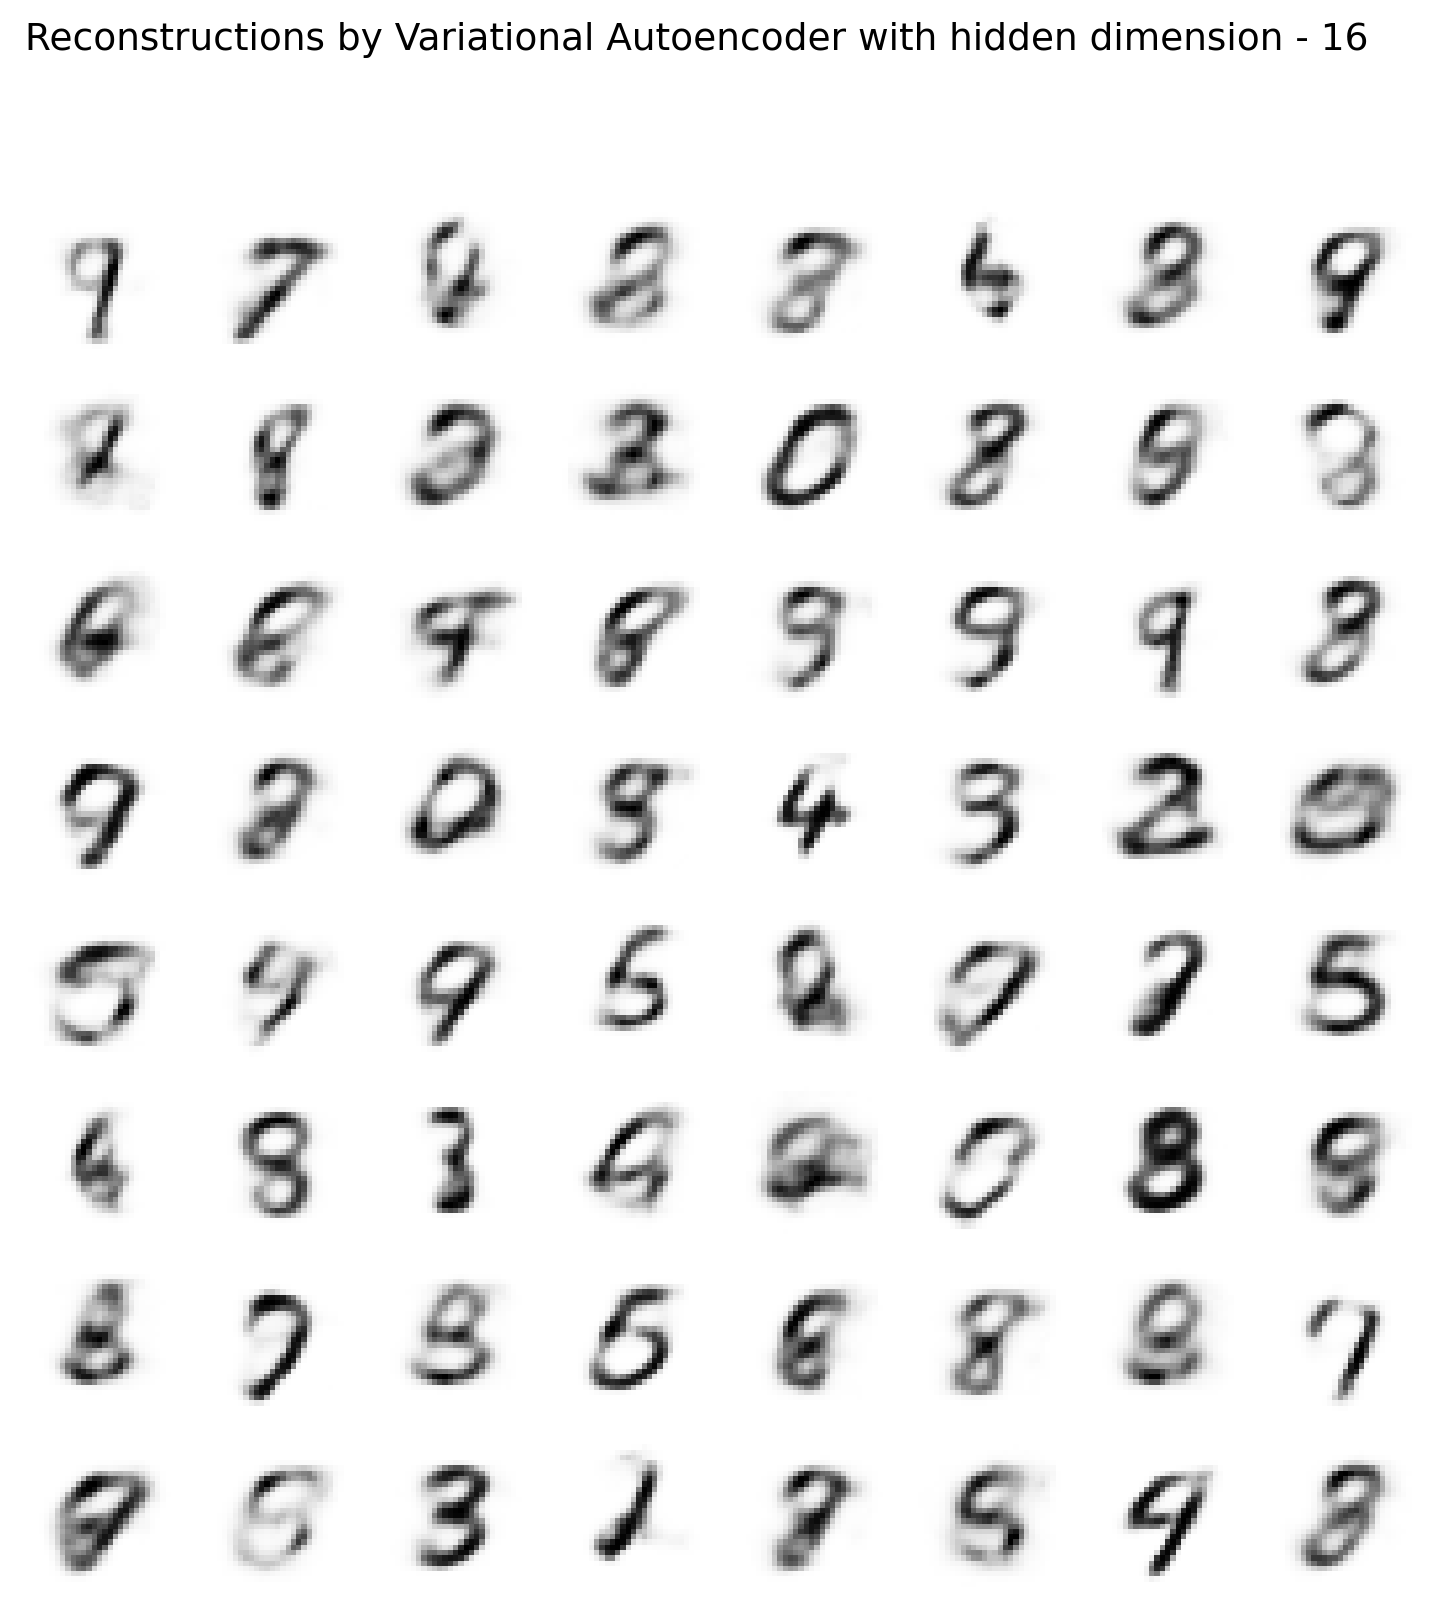

In [16]:
display_samples(samples)

###  **Observations**
 
<font size =5>In order to observe meaningful reconstructions the reconstruction loss had to be promoted by multiplying a *factor of 50*  (obtained experimentally). </font>

#  Question 3 Self Attention

In [17]:
# Used sir's slides for reference (Slide 27) :https://docs.google.com/presentation/d/15ifYMrvQtDrp20H8JWbP94Tifh8OWHlxXt1hiGfpyh0/edit#slide=id.g193b41dbc2d_0_262

class CNN_with_Attention(torch.nn.Module):

    def __init__(self):

        super(CNN_with_Attention, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size= 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),

            torch.nn.Conv2d(32, 64, kernel_size= 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(2,2),

            torch.nn.Dropout2d(p=0.3)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size= 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2,2),
            

            torch.nn.Conv2d(128, 256, kernel_size= 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout2d(p=0.5)
        )   

        # Self Attention here
        self.query = torch.nn.Conv2d(256, 32, kernel_size= 1)
        self.key = torch.nn.Conv2d(256, 32, kernel_size= 1)
        self.value = torch.nn.Conv2d(256, 32, kernel_size= 1)

        self.upscale = torch.nn.Conv2d(32, 256, kernel_size= 1)

        self.gap = torch.nn.Sequential(
                torch.nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc =  torch.nn.Sequential(
             torch.nn.Linear(256, 256),
             torch.nn.ReLU(),
             torch.nn.BatchNorm1d(256),
             torch.nn.Dropout(p=0.5) ,

             torch.nn.Linear(256, 10),
             torch.nn.Softmax(dim=1)
        )
        

    def forward(self, x):

        x = self.layer1(x)
        
        x = self.layer2(x)

        # Self Attention
        query, key, value = self.query(x), self.key(x), self.value(x)

        attention_weights = torch.nn.functional.softmax((torch.multiply(query, key)).reshape(-1, 32*2*2), dim=1)
        attention_weights = attention_weights.reshape(-1, 32, 2, 2)


        att_value  = torch.multiply(attention_weights, value)

        x = self.upscale(att_value) + x

        x = self.gap(x)

        x = x.reshape(-1, 256)

        x = self.fc(x)

        
        return x


In [18]:
cnn = CNN_with_Attention()

inputs= cifar10_trainset[:100]

outputs = cnn(inputs)
print(outputs.size())

torch.Size([100, 10])


In [19]:
def train_CNN(num_epochs = 50, batch_sz = 100):

    cnnAttention = CNN_with_Attention()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnnAttention.parameters(), lr=0.001)
    
    num_trainsamples = cifar10_trainset.shape[0]
    print(f"Starting training for CNN with self Attention ")
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0
        cnnAttention.train()
        for j in range(0, num_trainsamples, batch_sz):

            inputs = cifar10_trainset[j:j+batch_sz]
            labels = cifar10_trainlabels[j:j+batch_sz]

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = cnnAttention(inputs)     
            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1, keepdim=True).to(torch.uint8)
            true = torch.argmax(labels, dim=1, keepdim=True).to(torch.uint8)
            correct += (preds == true).sum()
        loss = (running_loss/num_trainsamples) * batch_sz
        accuracy = correct/num_trainsamples * 100
        print(f'Epoch = {epoch + 1} and loss: {loss}')
        print(f'Train Accuracy of CNN with Self-Attention after epoch = {epoch+1} is{accuracy: .2f}%\n')

    print(f'Finished training for CNN with self Attention \n')

    return cnnAttention

In [20]:
cnnAttention = train_CNN()

Starting training for CNN with self Attention 
Epoch = 1 and loss: 2.0417561361789702
Train Accuracy of CNN with Self-Attention after epoch = 1 is 42.07%

Epoch = 2 and loss: 1.9121452288627625
Train Accuracy of CNN with Self-Attention after epoch = 2 is 55.11%

Epoch = 3 and loss: 1.8667242591381072
Train Accuracy of CNN with Self-Attention after epoch = 3 is 59.37%

Epoch = 4 and loss: 1.83843297290802
Train Accuracy of CNN with Self-Attention after epoch = 4 is 62.20%

Epoch = 5 and loss: 1.8150611817836761
Train Accuracy of CNN with Self-Attention after epoch = 5 is 64.60%

Epoch = 6 and loss: 1.800821456193924
Train Accuracy of CNN with Self-Attention after epoch = 6 is 66.02%

Epoch = 7 and loss: 1.7892164437770843
Train Accuracy of CNN with Self-Attention after epoch = 7 is 67.05%

Epoch = 8 and loss: 1.7796406123638153
Train Accuracy of CNN with Self-Attention after epoch = 8 is 68.09%

Epoch = 9 and loss: 1.7698379347324371
Train Accuracy of CNN with Self-Attention after epoch

In [21]:
# Testing data Accuracy
cnnAttention.eval()
batch_sz = 100
num_testsamples = cifar10_testset.shape[0]
correct = 0
for j in range(0, num_testsamples, batch_sz):

    inputs = cifar10_testset[j:j+batch_sz]
    labels = cifar10_testlabels[j:j+batch_sz]
    
    outputs = cnnAttention(inputs)     
    labels = labels.float()

    preds = torch.argmax(outputs, dim=1, keepdim=True).to(torch.uint8)
    true = torch.argmax(labels, dim=1, keepdim=True).to(torch.uint8)
    correct += (preds == true).sum()

accuracy = correct/num_testsamples * 100
print(f'Final Test Accuracy of CNN with Self-Attention = {accuracy: .2f}%\n')

Final Test Accuracy of CNN with Self-Attention =  77.31%



- Note: Training the model on my machine (i5- 8th gen) took around 35 minutes for 20 epochs.